# Alternative Models: Searchlight, Parcellation, Networks

_Written by Frederic R. Hopp_

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from nltools.data import Brain_Data
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
from scipy.stats import sem, pearsonr
import scipy.stats as stats

from nilearn.plotting import plot_glass_brain

from nltools import expand_mask, collapse_mask
from nilearn.decoding import SearchLight
from nltools.mask import roi_to_brain, expand_mask, create_sphere

from nltools.stats import (
                           _calc_pvalue, 
                           correlation_permutation, 
                           summarize_bootstrap, 
                           threshold, 
                           fisher_r_to_z,
                           fdr,
                           zscore
)
from scipy.optimize import curve_fit
from tools import *
import nibabel as nib

from nltools.analysis import Roc

%matplotlib inline

In [5]:
def bootstrap_pearsonr_ci(x, y, n_bootstrap=10000, ci=95, random_state=None):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Remove NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    rng = np.random.default_rng(random_state)
    n = len(x)
    boot_corrs = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        boot_corrs[i], _ = pearsonr(x_sample, y_sample)
    
    # Compute the CI bounds
    lower = (100 - ci) / 2
    upper = 100 - lower
    ci_lower = np.percentile(boot_corrs, lower)
    ci_upper = np.percentile(boot_corrs, upper)
    
    # Original correlation
    corr, _ = pearsonr(x, y)
    
    return corr, (ci_lower, ci_upper), boot_corrs


def within_person_correlation(x, y, person_ids):
    df = pd.DataFrame({'x': x, 'y': y, 'person': person_ids})
    
    person_corrs = {}
    
    for person, group in df.groupby('person'):
        group = group.dropna(subset=['x', 'y'])
        if len(group) >= 2:  # Need at least 2 points to compute correlation
            corr, _ = pearsonr(group['x'], group['y'])
            person_corrs[person] = corr
        else:
            person_corrs[person] = np.nan
    
    # Compute mean of valid correlations
    valid_corrs = [c for c in person_corrs.values() if not np.isnan(c)]
    mean_corr = np.mean(valid_corrs) if valid_corrs else np.nan
    
    return round(mean_corr,2) , round(sem(valid_corrs),2)

# Load Parametric Maps and Subject Info

In [2]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_1/'

sub_list = [x.split('/')[-1].split('_')[0] for x in glob.glob(betas_dir+'sub*')]
sub_list.sort()

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 64 unique subjects
assert len(sub_info.subject.unique()) == 64

# We should have 256 beta maps
assert len(sub_info) == 64 * 4

***

# No Occipital Lobe

In [3]:
occ = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/talairach_atlas/lobe.nii.gz')
occ = expand_mask(occ)[8]
# Flip mask to get all but OCC
occ.data = np.abs(occ.data - 1)

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.89
overall CV Correlation: 0.71


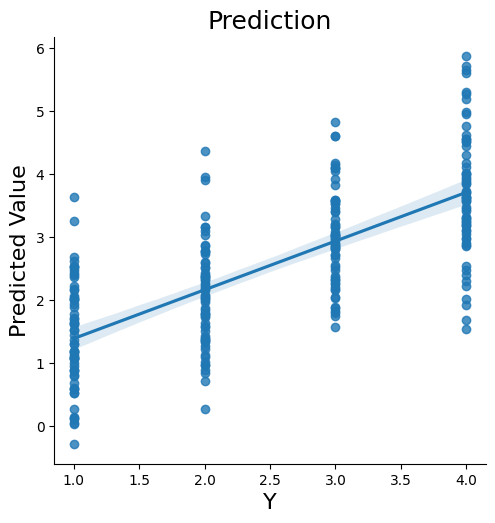

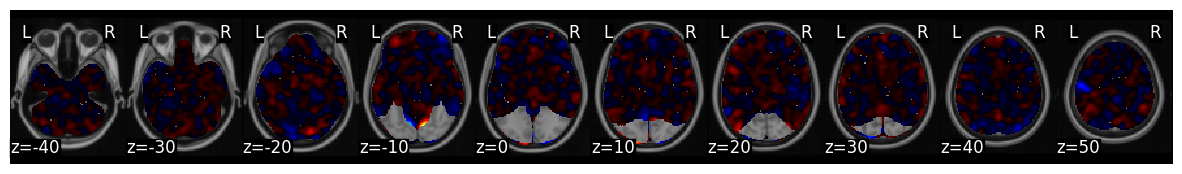

In [4]:
# Load beta files into Brain_Data object
moral_data = Brain_Data(betas).apply_mask(occ)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

# Remove subject mean and run svr
wb_stats = moral_data.standardize(axis=1).predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

In [ ]:
# with open('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights_no_occ.pkl', 'wb') as f:
#     pickle.dump(wb_stats, f)

In [8]:
mjs_no_occ_stats = pickle.load(open('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights_no_occ.pkl', 'rb'))

In [12]:
df_disc = pd.DataFrame()
df_disc['subject'] = sub_info['subject']
df_disc['ratings'] = sub_info['ratings']
df_disc['MJS'] = zscore(pd.Series(mjs_no_occ_stats['yfit_xval']))

In [14]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , df_disc['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_disc['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.71 7.62081465134382e-41
MJS 95% CI: [0.654, 0.764]




In [18]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_disc.ratings, df_disc['MJS'], df_disc.subject)

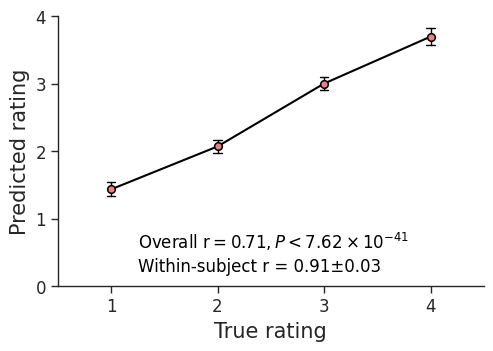

In [23]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study1_no_occ.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_disc[df_disc['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.84, p-value: P < 2.00 × 10⁻⁰⁸
Accuracy for 2 vs 3: 0.97, p-value: P < 2.26 × 10⁻¹⁶
Accuracy for 3 vs 4: 0.94, p-value: P < 7.36 × 10⁻¹⁴
Accuracy for 1 vs 3: 0.98, p-value: P < 7.05 × 10⁻¹⁸
Accuracy for 2 vs 4: 0.97, p-value: P < 2.26 × 10⁻¹⁶
Accuracy for 1 vs 4: 0.97, p-value: P < 2.26 × 10⁻¹⁶


## Validation Cohort

In [48]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_2/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x and 'sub-07' not in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

valid_data = Brain_Data(betas).standardize(axis=1).apply_mask(occ)
valid_data.X['subject'] = sub_info['subject']
valid_data.Y = sub_info['ratings']
subject_id = valid_data.X['subject']

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [51]:
df_valid = pd.DataFrame()
df_valid['subject'] = sub_info['subject']
df_valid['ratings'] = sub_info['ratings']
df_valid['MJS'] = valid_data.similarity(mjs_no_occ_stats['weight_map'], method='dot_product') + mjs_no_occ_stats['intercept']

In [52]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , df_valid['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_valid['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.54 2.2390020324808312e-10
MJS 95% CI: [0.415, 0.651]




In [53]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_valid.ratings, df_valid['MJS'], df_valid.subject)

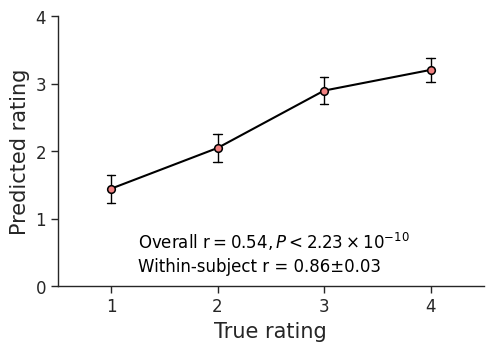

In [55]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], df_valid['MJS']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study2_no_occ.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_valid[df_valid['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.79, p-value: P < 2.32 × 10⁻⁰³
Accuracy for 2 vs 3: 0.97, p-value: P < 5.77 × 10⁻⁰⁸
Accuracy for 3 vs 4: 0.70, p-value: P < 4.28 × 10⁻⁰²
Accuracy for 1 vs 3: 0.97, p-value: P < 1.12 × 10⁻⁰⁷
Accuracy for 2 vs 4: 0.90, p-value: P < 8.43 × 10⁻⁰⁶
Accuracy for 1 vs 4: 1.00, p-value: P < 3.73 × 10⁻⁰⁹


## Replication Cohort

In [59]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/duke/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled']
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 27

repl_data = Brain_Data(betas).standardize(axis=1).apply_mask(occ)
repl_data.X['subject'] = sub_info['subject']
repl_data.Y = sub_info['ratings']
subject_id = repl_data.X['subject']

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [60]:
df_repl = pd.DataFrame()
df_repl['subject'] = sub_info['subject']
df_repl['ratings'] = sub_info['ratings']
df_repl['MJS'] = repl_data.similarity(mjs_no_occ_stats['weight_map'], method='dot_product') + mjs_no_occ_stats['intercept']

In [61]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , df_repl['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_repl['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.51 1.862763533464664e-08
MJS 95% CI: [0.369, 0.636]




In [62]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_repl.ratings, df_repl['MJS'], df_repl.subject)

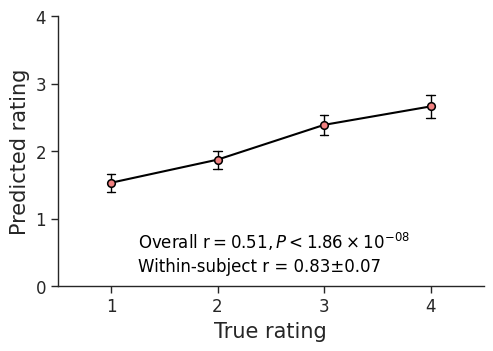

In [63]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], df_repl['MJS']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study3_no_occ.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_repl[df_repl['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.81, p-value: P < 1.51 × 10⁻⁰³
Accuracy for 2 vs 3: 0.96, p-value: P < 4.17 × 10⁻⁰⁷
Accuracy for 3 vs 4: 0.70, p-value: P < 5.22 × 10⁻⁰²
Accuracy for 1 vs 3: 0.96, p-value: P < 4.17 × 10⁻⁰⁷
Accuracy for 2 vs 4: 0.89, p-value: P < 4.92 × 10⁻⁰⁵
Accuracy for 1 vs 4: 0.96, p-value: P < 4.17 × 10⁻⁰⁷


## Generalization

In [67]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/uva/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled']
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

gen_data = Brain_Data(betas).standardize(axis=1).apply_mask(occ)
gen_data.X['subject'] = sub_info['subject']
gen_data.Y = sub_info['ratings']
subject_id = gen_data.X['subject']

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [68]:
df_gen = pd.DataFrame()
df_gen['subject'] = sub_info['subject']
df_gen['ratings'] = sub_info['ratings']
df_gen['MJS'] = gen_data.similarity(mjs_no_occ_stats['weight_map'], method='dot_product') + mjs_no_occ_stats['intercept']

In [69]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , df_gen['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_gen['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.39 1.3228924003084085e-05
MJS 95% CI: [0.229, 0.524]




In [70]:
mjs_r_within, mjs_r_within_se =  within_person_correlation(df_gen.ratings, df_gen['MJS'], df_gen.subject)

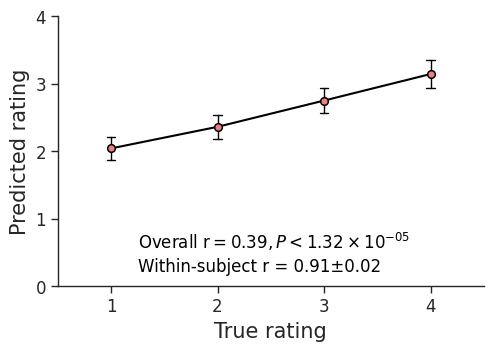

In [71]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], df_gen['MJS']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {mjs_r_within}±{mjs_r_within_se}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study4_no_occ.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
cominations = [(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]
for c in cominations:
    fc_data = df_gen[df_gen['ratings'].isin(c)]
    fc_data = fc_data.groupby(['subject','ratings'])[['MJS']].mean().reset_index()
    fc_data = fc_data.dropna()
    fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==c[1] else False)
    fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
    fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

    roc = Roc(input_values=np.array(fc_data["MJS"].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.calculate()
    acc = roc.accuracy
    p_value = roc.accuracy_p.pvalue
    mantissa, exponent = f"{p_value:.2e}".split("e")
    exponent = exponent.lstrip("+-").replace("0", "⁰").replace("1", "¹").replace("2", "²").replace("3", "³").replace("4", "⁴").replace("5", "⁵").replace("6", "⁶").replace("7", "⁷").replace("8", "⁸").replace("9", "⁹")
    formatted_p = f"{mantissa} × 10⁻{exponent}"

    print(f'Accuracy for {c[0]} vs {c[1]}: {acc:.2f}, p-value: P < {formatted_p}')

Accuracy for 1 vs 2: 0.90, p-value: P < 8.43 × 10⁻⁰⁶
Accuracy for 2 vs 3: 0.93, p-value: P < 8.68 × 10⁻⁰⁷
Accuracy for 3 vs 4: 0.90, p-value: P < 8.43 × 10⁻⁰⁶
Accuracy for 1 vs 3: 0.97, p-value: P < 5.77 × 10⁻⁰⁸
Accuracy for 2 vs 4: 1.00, p-value: P < 1.86 × 10⁻⁰⁹
Accuracy for 1 vs 4: 1.00, p-value: P < 1.86 × 10⁻⁰⁹


***

# Parcellation

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


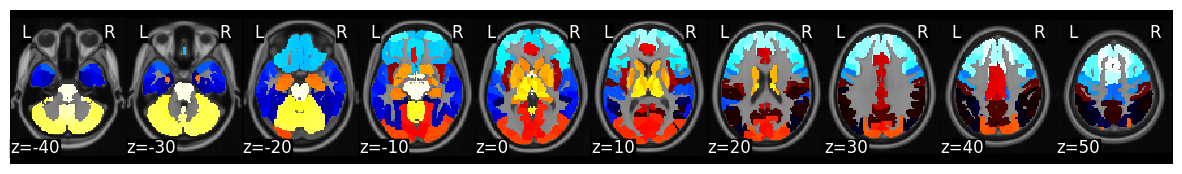

In [4]:
atlas = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/Fan_et_al_atlas_r279_MNI.nii')
atlas_x = expand_mask(atlas)
atlas.plot()

## Discovery Cohort

In [ ]:
# Load beta files into Brain_Data object
moral_data = Brain_Data(betas)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

# Remove subject mean and run svr
wb_stats = moral_data.standardize(axis=1).predict_multi(algorithm='svr', method='rois', rois=atlas_x,n_jobs=-1,
                              cv_dict={'type': 'loso','subject_id': subject_id}, **{'kernel':"linear"})

# with open('weightmaps/mjs/mjs_svr_parcellation.pkl', 'wb') as f:
#     pickle.dump(wb_stats, f)

In [12]:
wb_stats = pd.read_pickle("/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_svr_parcellation.pkl")

In [18]:
df_bn = pd.DataFrame(columns=[['roi_ix', 'r_xval']])

for i, stats in enumerate(wb_stats):
    df_bn.at[i, 'roi_ix'] = i
    df_bn.at[i, 'r_xval'] = stats['r_xval']

    # Get p-value for correlation

    p = pearsonr(stats['Y'] , stats['yfit_xval'])[1]
    df_bn.at[i, 'p'] = p

In [19]:
brain_r = roi_to_brain(df_bn['r_xval'], atlas_x)
brain_p = roi_to_brain(df_bn['p'], atlas_x)
fdr_thr = fdr(df_bn['p'].values, q=0.003)[0]
thresholded = threshold(brain_r[0], brain_p[0], thr=fdr_thr)

/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [20]:
# seaborn reset style
sns.set_theme("paper")
# set seaborn style to just be white no grid
sns.set_style("ticks")

/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/fhopp/.conda/envs/mjs/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


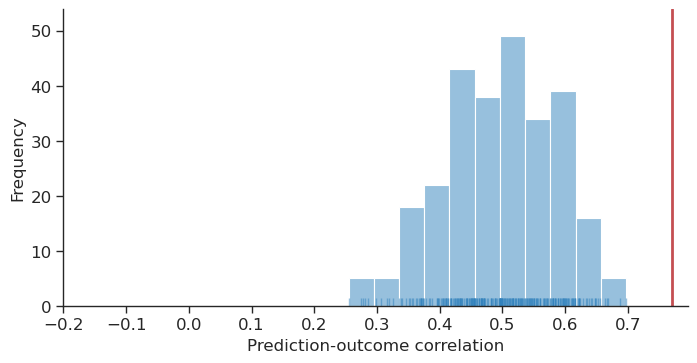

In [21]:
# fig, ax = plt.subplots(figsize=(5.5,3.5))
sns.displot(df_bn['r_xval'], aspect=2, palette='tab20c', height=3.5, rug=True, rug_kws={'lw':1, 'alpha':.5, 'clip_on':'False'}, legend=False)
sns.despine()
# Add vertical line
plt.axvline(0.77, color='r', linewidth=2)
# Create 0.2 steps for x-axis
plt.xticks(np.arange(-0.2, 0.8, 0.1))
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Prediction-outcome correlation", fontsize=12)
# make yticks larger
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('plots/mjs_study1_svr_parcellation_dist.png', dpi=300, bbox_inches='tight')

In [23]:
thresholded.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [95]:
thresholded.write('weightmaps/mjs/mjs_parcels_thresh.nii.gz')

***
## Validation Cohort

In [3]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_2/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x and 'sub-07' not in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

valid_data = Brain_Data(betas).standardize(axis=1)
valid_data.X['subject'] = sub_info['subject']
valid_data.Y = sub_info['ratings']
subject_id = valid_data.X['subject']

In [ ]:
# Remove subject mean and run svr
wb_stats = valid_data.predict_multi(algorithm='svr', method='rois', rois=atlas_x,n_jobs=-1,
                              cv_dict={'type': 'loso','subject_id': subject_id}, **{'kernel':"linear"})


with open('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_svr_valid_parcellation.pkl', 'wb') as f:
    pickle.dump(wb_stats, f)

In [ ]:
wb_stats = pd.read_pickle("/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_svr_valid_parcellation.pkl")

In [8]:
df_bn = pd.DataFrame(columns=[['roi_ix', 'r_xval']])

for i, stats in enumerate(wb_stats):
    df_bn.at[i, 'roi_ix'] = i
    df_bn.at[i, 'r_xval'] = stats['r_xval']

    # Get p-value for correlation

    p = pearsonr(stats['Y'] , stats['yfit_xval'])[1]
    df_bn.at[i, 'p'] = p

In [11]:
brain_r = roi_to_brain(df_bn['r_xval'], atlas_x)
brain_p = roi_to_brain(df_bn['p'], atlas_x)
thresholded = threshold(brain_r[0], brain_p[0], thr=0.001)

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [17]:
thresholded.write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_valid_parcels_thresh.nii.gz')

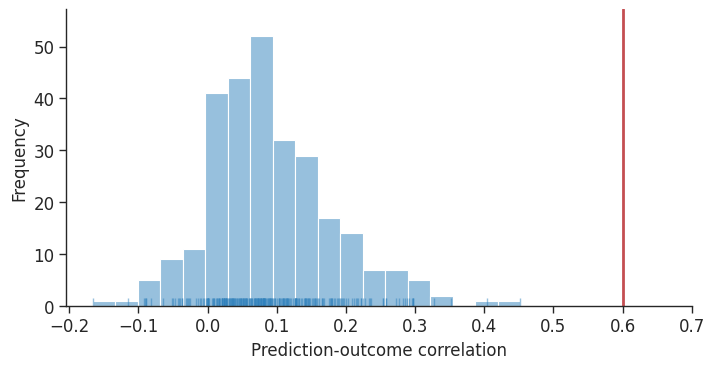

In [13]:
# seaborn reset style
sns.set_theme("paper")
# set seaborn style to just be white no grid
sns.set_style("ticks")

# fig, ax = plt.subplots(figsize=(5.5,3.5))
sns.displot(df_bn['r_xval'], aspect=2, palette='tab20c', height=3.5, rug=True, rug_kws={'lw':1, 'alpha':.5, 'clip_on':'False'}, legend=False)
sns.despine()
# Add vertical line
plt.axvline(0.6, color='r', linewidth=2)
# Create 0.2 steps for x-axis
plt.xticks(np.arange(-0.2, 0.8, 0.1))
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Prediction-outcome correlation", fontsize=12)
# make yticks larger
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study2_svr_parcellation_dist.png', dpi=300, bbox_inches='tight')

***

# Searchlight

**N.B.** A modified version of the SearchLight function from nilearn was implemented. Here, for each sphere, the Pearson correlation (and p-values) was computed for all cross-validated (LOSO) predictions and true ratings *across* subjects (256 predictions/searchlight).  
The original Searchlight method computes scores *within* each participant. 

Alternatively, use the searchlight from CanlabCore in matlab, which by default computes across-participant predictions.

## Discovery Cohort

In [ ]:
# Load beta files into Brain_Data object
moral_data = Brain_Data(betas).standardize(axis=1)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

In [5]:
# Run searchlight analysis
sl = SearchLight(mask_img=moral_data.mask, 
                 radius=3.0, estimator="svr", n_jobs=-1
                 )

sl.fit(moral_data.to_nifti(), np.array(moral_data.Y), np.array(subject_id))

SearchLight(estimator='svr',
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f8e80576340>,
            n_jobs=-1, radius=3.0)

In [7]:
out_r = nib.Nifti1Image(sl.corrs_, affine=moral_data.nifti_masker.affine_)
out_p = nib.Nifti1Image(sl.p_values_, affine=moral_data.nifti_masker.affine_)

In [19]:
# fdr_thr = fdr(Brain_Data(out_p).data, q=0.005)
thresholded = threshold(Brain_Data(out_r), Brain_Data(out_p), thr=0.001)

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [23]:
thresholded.write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_study1_searchlight_thresh.nii.gz')
Brain_Data(out_r).write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_study1_searchlight.nii.gz')

/tmp/ipykernel_3739471/1633030985.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(Brain_Data(out_r).data, aspect=2, palette='tab20c', height=3.5, rug=True, rug_kws={'lw':1, 'alpha':.01, 'clip_on':'False'})


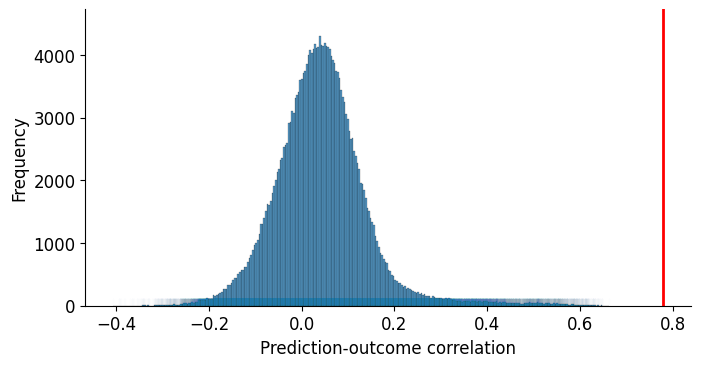

In [25]:
 sns.displot(Brain_Data(out_r).data, aspect=2, palette='tab20c', height=3.5, rug=True, rug_kws={'lw':1, 'alpha':.01, 'clip_on':'False'})
sns.despine()
# Add vertical line
plt.axvline(0.78, color='r', linewidth=2)
# Create 0.2 steps for x-axis
# plt.xticks(np.arange(-0.2, 0.8, 0.1))
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Prediction-outcome correlation", fontsize=12)
# make yticks larger
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study1_svr_searchlight_dist.png', dpi=300, bbox_inches='tight')
plt.show()

***
## Validation

In [14]:
# Run searchlight analysis
sl = SearchLight(mask_img=valid_data.mask, 
                 radius=3.0, estimator="svr", n_jobs=-1
                 )

sl.fit(valid_data.to_nifti(), np.array(valid_data.Y), np.array(subject_id))

SearchLight(estimator='svr',
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fabeb6bc7c0>,
            n_jobs=-1, radius=3.0)

In [15]:
out_r = nib.Nifti1Image(sl.corrs_, affine=valid_data.nifti_masker.affine_)
out_p = nib.Nifti1Image(sl.p_values_, affine=valid_data.nifti_masker.affine_)

In [18]:
# fdr_thr = fdr(Brain_Data(out_p).data, q=0.005)
thresholded = threshold(Brain_Data(out_r), Brain_Data(out_p), thr=0.001)

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [20]:
thresholded.write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_study2_searchlight_thresh.nii.gz')

/tmp/ipykernel_130957/3171259610.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(Brain_Data(out_r).data, aspect=2, palette='tab20c', height=3.5, rug=True, rug_kws={'lw':1, 'alpha':.01, 'clip_on':'False'})


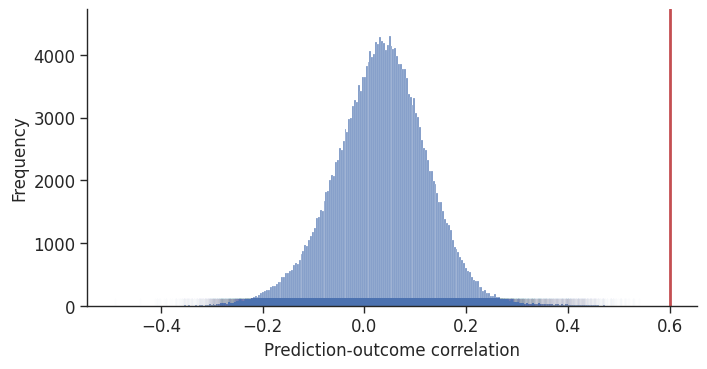

In [21]:
 sns.displot(Brain_Data(out_r).data, aspect=2, palette='tab20c', height=3.5, rug=True, rug_kws={'lw':1, 'alpha':.01, 'clip_on':'False'})
sns.despine()
# Add vertical line
plt.axvline(0.6, color='r', linewidth=2)
# Create 0.2 steps for x-axis
# plt.xticks(np.arange(-0.2, 0.8, 0.1))
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Prediction-outcome correlation", fontsize=12)
# make yticks larger
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study2_svr_searchlight_dist.png', dpi=300, bbox_inches='tight')
plt.show()

***
# dmPFC & vmPFC

## Discovery

In [ ]:
dmpfc_mask = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/dmpfc_mask.nii.gz')
vmpfc_mask = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/vmpfc_mask.nii.gz')

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


overall Root Mean Squared Error: 0.29
overall Correlation: 0.97
overall CV Root Mean Squared Error: 2.75
overall CV Correlation: 0.18


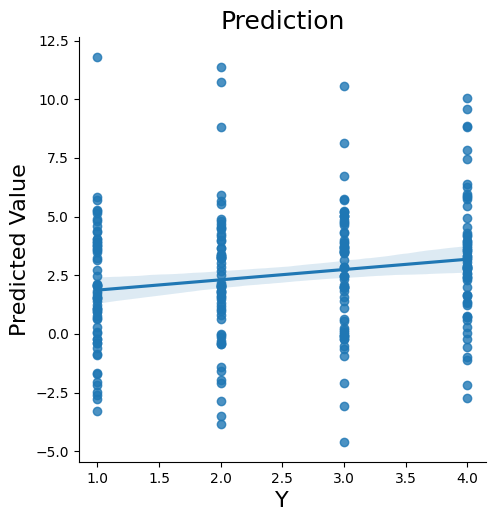

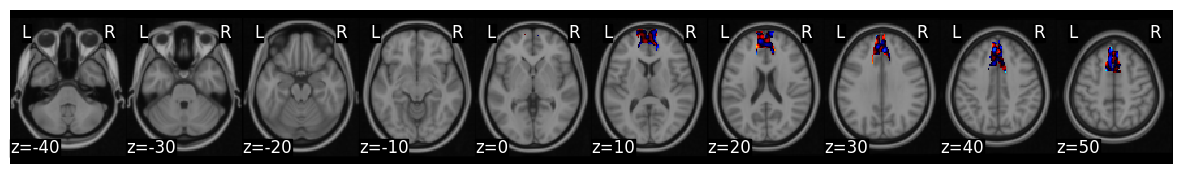

In [4]:
# Load beta files into Brain_Data object
moral_data = Brain_Data(betas).apply_mask(dmpfc_mask)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

# Remove subject mean and run svr
wb_stats = moral_data.standardize(axis=1).predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

In [5]:
all_r, all_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])
all_rmse = mean_squared_error(sub_info['ratings'] , wb_stats['yfit_xval'], squared=False)

per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(wb_stats['yfit_xval'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(mean_squared_error(true, pred, squared=False))

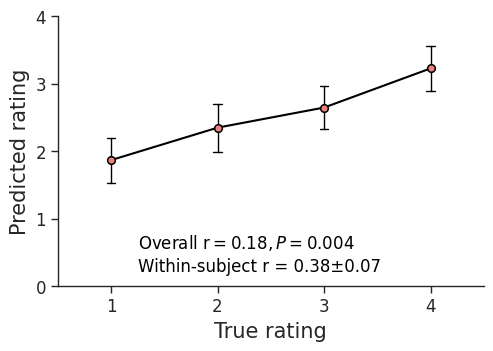

In [22]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P = {}$'.format(round(all_r, 2), str(round(all_p, 3))),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {round(np.mean(within_r), 2)}±{round(scipy.stats.sem(within_r), 2)}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study1_dmPFC.png', dpi=300, bbox_inches='tight')
plt.show()

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


overall Root Mean Squared Error: 0.34
overall Correlation: 0.95
overall CV Root Mean Squared Error: 1.87
overall CV Correlation: 0.27


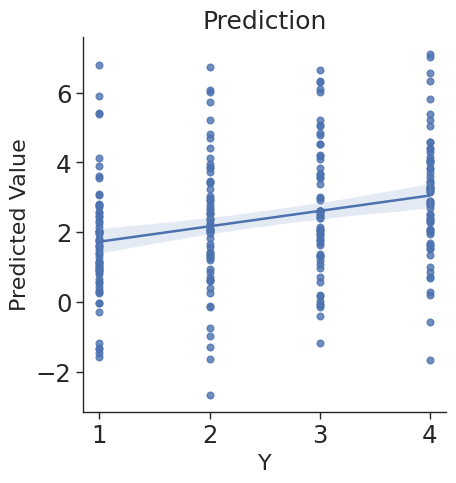

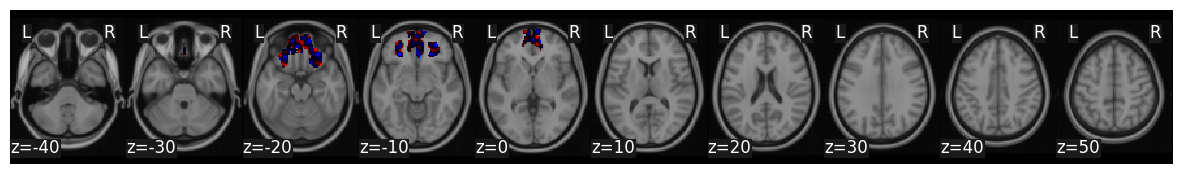

In [23]:
# Load beta files into Brain_Data object
moral_data = Brain_Data(betas).apply_mask(vmpfc_mask)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

# Remove subject mean and run svr
wb_stats = moral_data.standardize(axis=1).predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

In [24]:
all_r, all_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])
all_rmse = mean_squared_error(sub_info['ratings'] , wb_stats['yfit_xval'], squared=False)

per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(wb_stats['yfit_xval'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(mean_squared_error(true, pred, squared=False))

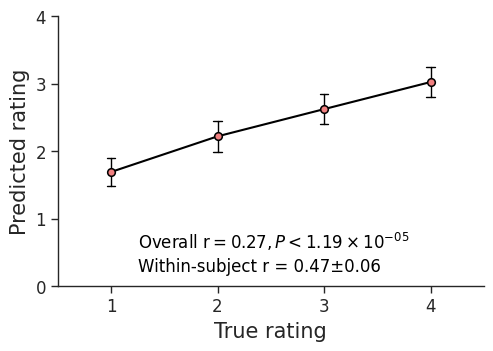

In [27]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(all_r, 2), str(all_p)[0:4], str(all_p)[-2:]),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {round(np.mean(within_r), 2)}±{round(scipy.stats.sem(within_r), 2)}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study1_vmPFC.png', dpi=300, bbox_inches='tight')
plt.show()

***
## Validation

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 3.21
overall CV Correlation: 0.12


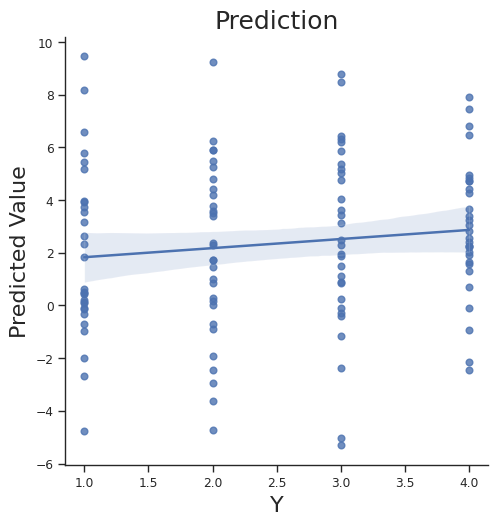

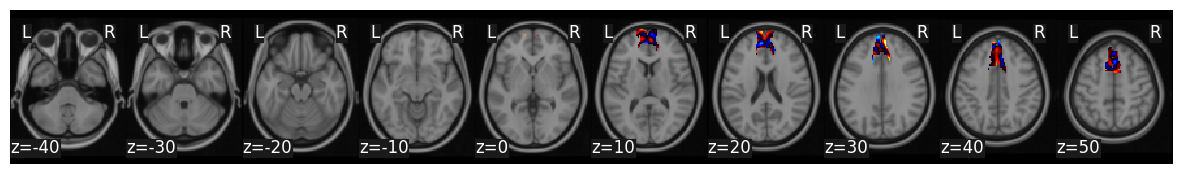

In [23]:
# Remove subject mean and run svr
wb_stats = valid_data.apply_mask(dmpfc_mask).standardize(axis=1).predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

In [26]:
all_r, all_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])
all_rmse = mean_squared_error(sub_info['ratings'] , wb_stats['yfit_xval'], squared=False)

per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(wb_stats['yfit_xval'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(mean_squared_error(true, pred, squared=False))

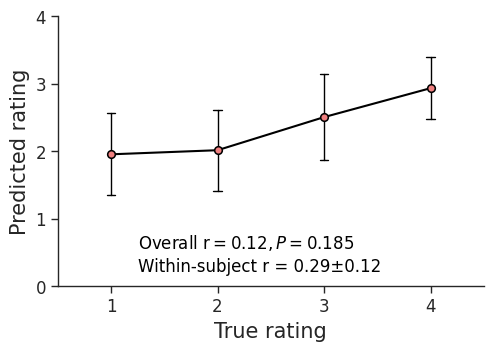

In [27]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P = {}$'.format(round(all_r, 2), str(round(all_p, 3))),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {round(np.mean(within_r), 2)}±{round(scipy.stats.sem(within_r), 2)}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study2_dmPFC.png', dpi=300, bbox_inches='tight')
plt.show()

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


overall Root Mean Squared Error: 0.11
overall Correlation: 1.00
overall CV Root Mean Squared Error: 2.98
overall CV Correlation: 0.13


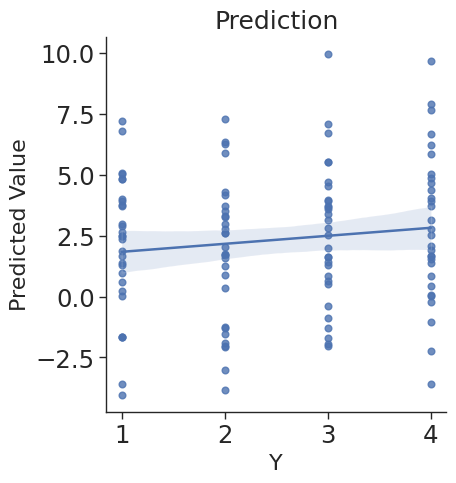

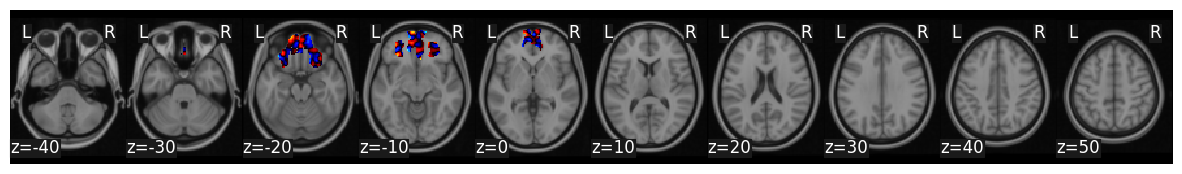

In [29]:
# Remove subject mean and run svr
wb_stats = valid_data.apply_mask(vmpfc_mask).standardize(axis=1).predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

In [30]:
all_r, all_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])
all_rmse = mean_squared_error(sub_info['ratings'] , wb_stats['yfit_xval'], squared=False)

per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(wb_stats['yfit_xval'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(mean_squared_error(true, pred, squared=False))

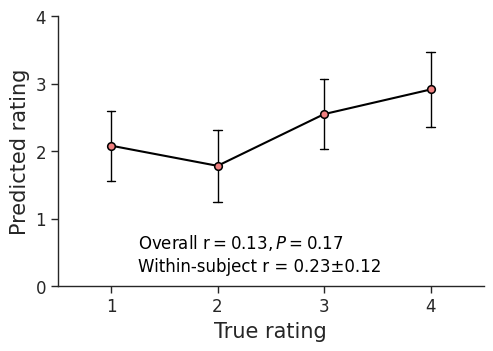

In [31]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P = {}$'.format(round(all_r, 2), str(round(all_p, 3))),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {round(np.mean(within_r), 2)}±{round(scipy.stats.sem(within_r), 2)}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study2_vmPFC.png', dpi=300, bbox_inches='tight')
plt.show()

***
# Neurosynth Moral Mask

Supply as extended data/SI analysis.

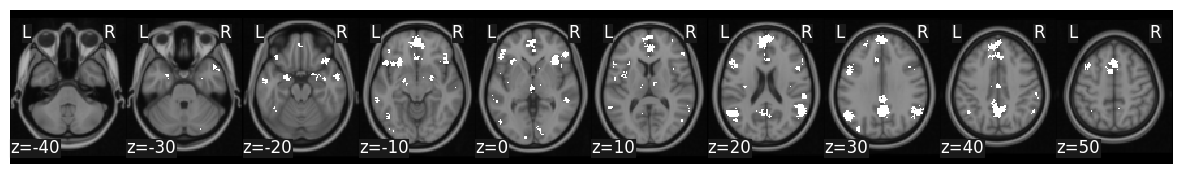

In [29]:
ns_moral = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/moral_uniformity-test_z_FDR_0.01.nii.gz').threshold(binarize=True)
ns_moral.plot()

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.35
overall CV Correlation: 0.54


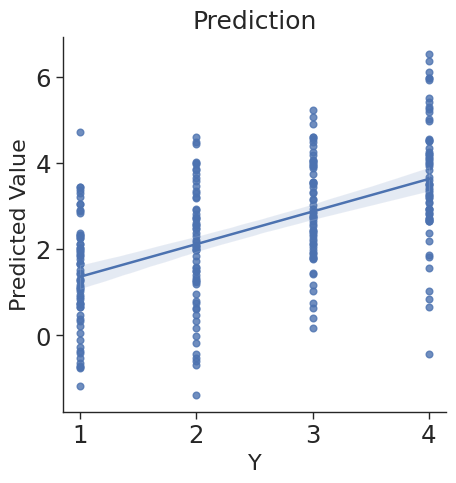

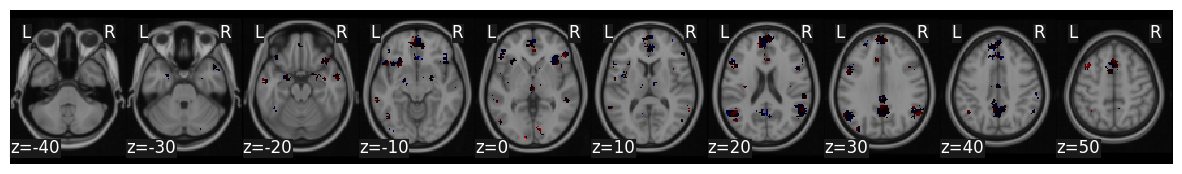

In [30]:
# Load beta files into Brain_Data object
moral_data = Brain_Data(betas).apply_mask(ns_moral)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

# Remove subject mean and run svr
wb_stats = moral_data.standardize(axis=1).predict(algorithm='svr', 
                              cv_dict={'type': 'loso','subject_id': subject_id}, 
                                                  plot=True, **{'kernel':"linear"})

In [33]:
all_r, all_p = stats.pearsonr(sub_info['ratings'] , wb_stats['yfit_xval'])
all_rmse = mean_squared_error(sub_info['ratings'] , wb_stats['yfit_xval'], squared=False)

per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info.subject.unique()))]
per_subject_predictions = [x for x in np.array_split(wb_stats['yfit_xval'], len(sub_info.subject.unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    within_rmse.append(mean_squared_error(true, pred, squared=False))

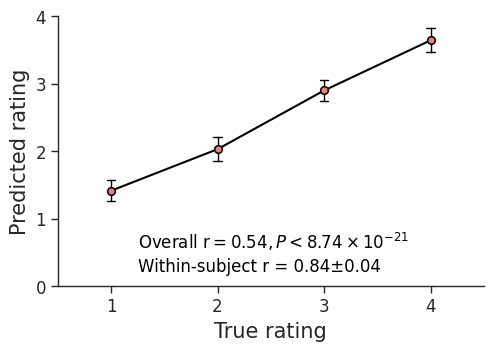

In [34]:
df_comp = pd.DataFrame(data=[sub_info['ratings'], wb_stats['yfit_xval']]).T
df_comp.columns = ['true', 'predicted']

#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5.5,3.5))

sns.pointplot(x='true', y='predicted', data=df_comp, linewidth=1.5, color='black', capsize=0.08, errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})

ax.text(0.25, 0.55, r'$\mathrm{{Overall\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(all_r, 2), str(all_p)[0:4], str(all_p)[-2:]),
        color='black', fontsize=12)

ax.text(0.25, 0.21, f'Within-subject r = {round(np.mean(within_r), 2)}±{round(scipy.stats.sem(within_r), 2)}',
        color='black', fontsize=12)

sns.despine()
plt.yticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings'])+1, 1.0))
plt.xticks(np.arange(min(sub_info['ratings'])-1, max(sub_info['ratings']), 1.0))
ax.set_xticklabels(['1','2','3','4'], fontsize=12)
ax.set_yticklabels(['0','1','2','3','4'], fontsize=12)
plt.ylabel('Predicted rating',fontsize=15)
plt.xlabel('True rating', fontsize=15)

plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/mjs_study1_neurosynth.png', dpi=300, bbox_inches='tight')
plt.show()

***

# Spatial Scale Evaluation

Next, we examine the spatial scale of the MJS by repeatedly (1000 times) sampling different amounts of voxels across the brain before training and evaluating the predictions.

We do this across the whole-brain (see file `spatial_scale.py`) and across nine different networks.

**Note.** The concsiousness network from [LeDoux](https://psychiatryonline.org/doi/full/10.1176/appi.ajp.2016.16030353) was created manually by identifying parcels from Fan et al. 279. Please see the code cell below. 

In [ ]:
# Extract parcels for consciousness network from Fan et al. 279

# bna = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/Fan_et_al_atlas_r279_MNI.nii')
# bna_x = expand_mask(atlas)

# fan_labels = pd.read_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/fan_279_labels.csv', sep=';', usecols=['roi'])
# fan_labels['roi'] = fan_labels['roi'].str.replace("'", '')
# fan_labels['idx'] = fan_labels.index
# fan_labels['consciousness'] = False

# N.B. see "consciousness_network" in tools.py for mapping
# for roi, parcels in consciousness_network.items():
#     for parcel in parcels:
#         fan_labels.loc[fan_labels['roi'] == parcel, 'consciousness'] = True

# fan_labels = fan_labels[fan_labels['consciousness'] == True]
# consc_idx = fan_labels['idx'].values

# consc_mask = collapse_mask(bna_x[consc_idx]).threshold(binarize=True)
# consc_mask.write('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/masks/consciousness_mask.nii.gz')

In [3]:
# Get whole-brain evaluations 
spatial_files = glob.glob("/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/spatial_scale/*/spatial_scale_*.pkl")
spatial_files.sort()

dfs = []
for f in spatial_files:
    if "whole_brain" in f:
        data = pd.read_pickle(f)
        df = pd.DataFrame([{k: v for d in data for k, v in d.items()}]).T
        df.columns = ['r']
        df['network'] = 'Whole-brain'
    else:
        data = pd.read_pickle(f)
        df = pd.DataFrame.from_dict(data, orient='index', columns=['r'])
        df['network'] = f.split('/')[-1].split('_')[-2].split('.')[0]
    
    dfs.append(df)

df = pd.concat(dfs).reset_index()
df = df.rename(columns={'index': 'n_voxels'})

df_grouped = df.groupby(["n_voxels", 'network']).agg(["mean", "std"]).reset_index()
df_grouped.columns = ["n_voxels", "network", "r_mean", "r_std"]

In [5]:
sns.set_theme()
sns.set_context('paper', font_scale=1.5)
sns.set_style("ticks")

/tmp/ipykernel_4072020/2684206062.py:55: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 10**6)


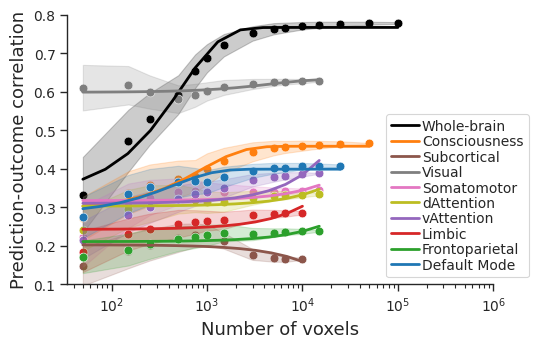

In [6]:
network_cmap = {'Whole-brain': 'black', 
                'Consciousness': sns.color_palette("tab10", 10)[1], 
                'Subcortical': sns.color_palette("tab10", 10)[5],
                'Visual': sns.color_palette("tab10", 10)[7],
                'Somatomotor': sns.color_palette("tab10", 10)[6],
                'dAttention': sns.color_palette("tab10", 10)[8],
                'vAttention': sns.color_palette("tab10", 10)[4],
                'Limbic': sns.color_palette("tab10", 10)[3],
                'Frontoparietal': sns.color_palette("tab10", 10)[2],
                'Default Mode': sns.color_palette("tab10", 10)[0]
                }

# Define function (similar to MATLAB's fittype)
def model_func(x, a, b, c):
    return (1 - b * np.exp(-a * x)) + c

fig, ax = plt.subplots(figsize=(5.5,3.5))

for network, color in network_cmap.items():

    subset = df_grouped[df_grouped['network'] == network]

    # Fit the Model to the Mean Data
    popt, _ = curve_fit(model_func, subset["n_voxels"], subset["r_mean"], 
                    p0=[0.00001, 0.5, subset["r_mean"].min()])

    # Generate Smoothed Curve Data
    x_smooth = np.logspace(np.log10(subset["n_voxels"].min()), np.log10(subset["n_voxels"].max()), 15)
    y_smooth = model_func(x_smooth, *popt)

    # Plot Mean Data Points
    sns.scatterplot(x=subset["n_voxels"], y=subset["r_mean"], color=color, s=40)

    # Plot Fitted Curve
    plt.plot(x_smooth, y_smooth, color=color, linewidth=2, label=network)

    # Plot Standard Deviation as a Shaded Region
    plt.fill_between(
        subset["n_voxels"],
        subset["r_mean"] - subset["r_std"],
        subset["r_mean"] + subset["r_std"],
        color=color,
        alpha=0.2,  # Transparency
    )

plt.ylim(0.1, 0.8)
# Set x-axis limit to 10^6
sns.despine()

# place legend at bottom right
plt.legend(loc='lower right', prop={'size': 10}, bbox_to_anchor=(1.1, 0), labelspacing=0.1, handletextpad=0.2)

# Log-scale X-axis
plt.xscale("log")
plt.xlim(0, 10**6)

# change size of ytick labels
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.xlabel("Number of voxels", fontsize=13)
plt.ylabel("Prediction-outcome correlation", fontsize=13)
plt.savefig('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/plots/spatial_scale.png', dpi=300, bbox_inches='tight')
plt.show()